In [ ]:
# prompt: mount drive to colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adrianboguszewski/landcoverai

Dataset URL: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai
License(s): CC-BY-NC-SA-4.0
... resuming from 253755392 bytes (1284615158 bytes left) ...
100% 1.43G/1.43G [00:12<00:00, 134MB/s]
100% 1.43G/1.43G [00:16<00:00, 79.7MB/s]


In [ ]:
!unzip landcoverai.zip

Archive:  landcoverai.zip
  inflating: images/M-33-20-D-c-4-2.tif  
  inflating: images/M-33-20-D-d-3-3.tif  
  inflating: images/M-33-32-B-b-4-4.tif  
  inflating: images/M-33-48-A-c-4-4.tif  
  inflating: images/M-33-7-A-d-2-3.tif  
  inflating: images/M-33-7-A-d-3-2.tif  
  inflating: images/M-34-32-B-a-4-3.tif  
  inflating: images/M-34-32-B-b-1-3.tif  
  inflating: images/M-34-5-D-d-4-2.tif  
  inflating: images/M-34-51-C-b-2-1.tif  
  inflating: images/M-34-51-C-d-4-1.tif  
  inflating: images/M-34-55-B-b-4-1.tif  
  inflating: images/M-34-56-A-b-1-4.tif  
  inflating: images/M-34-6-A-d-2-2.tif  
  inflating: images/M-34-65-D-a-4-4.tif  
  inflating: images/M-34-65-D-c-4-2.tif  
  inflating: images/M-34-65-D-d-4-1.tif  
  inflating: images/M-34-68-B-a-1-3.tif  
  inflating: images/M-34-77-B-c-2-3.tif  
  inflating: images/N-33-104-A-c-1-1.tif  
  inflating: images/N-33-119-C-c-3-3.tif  
  inflating: images/N-33-130-A-d-3-3.tif  
  inflating: images/N-33-130-A-d-4-4.tif  
  inflat

In [ ]:
import os
from osgeo import gdal
from PIL import Image
from pyproj import Proj, Transformer

def split_and_store_with_geographic_coords(input_folder, output_folder, txt_output):
    """
    Splits orthophotos into 512x512 subsections, recalculates geographic coordinates, and saves them in decimal degrees.

    Parameters:
    - input_folder: Path to the folder containing input TIFF images.
    - output_folder: Path to save 512x512 split images.
    - txt_output: Path to save the coordinates of each subimage.
    """
    os.makedirs(output_folder, exist_ok=True)

    with open(txt_output, 'w') as coord_file:
        coord_file.write("image_id,upper_left_lat_dec,upper_left_lon_dec,lower_right_lat_dec,lower_right_lon_dec\n")

        for filename in os.listdir(input_folder):
            if filename.endswith(".tif"):
                filepath = os.path.join(input_folder, filename)
                dataset = gdal.Open(filepath)
                geotransform = dataset.GetGeoTransform()
                origin_x, pixel_width, _, origin_y, _, pixel_height = geotransform
                proj = dataset.GetProjection()

                img = Image.open(filepath)
                img_width, img_height = img.size

                # Assuming the image uses UTM, extract UTM zone from filename or set manually
                #utm_code = filename.split('-')[1]  # Assuming zone is embedded in filename
                #utm_zone = int(utm_code)  # Extract UTM zone
                in_proj = Proj(init='epsg:2180')
                out_proj = Proj(init="epsg:4326")  # WGS84 projection

                transformer = Transformer.from_proj(in_proj, out_proj, always_xy=True)

                # Iterate over each 512x512 section of the image
                for i in range(0, img_width, 512):
                    for j in range(0, img_height, 512):
                        subimage = img.crop((i, j, min(i+512, img_width), min(j+512, img_height)))
                        subimage_id = f"{filename[:-4]}_{i}_{j}.tif"
                        subimage_path = os.path.join(output_folder, subimage_id)
                        subimage.save(subimage_path)

                        # Calculate projected coordinates for the upper left and lower right corners of the subimage
                        upper_left_x = origin_x + i * pixel_width
                        upper_left_y = origin_y + j * pixel_height
                        lower_right_x = upper_left_x + (min(512, img_width - i) * pixel_width)
                        lower_right_y = upper_left_y + (min(512, img_height - j) * pixel_height)

                        # Convert UTM coordinates to geographic coordinates in decimal degrees (latitude, longitude)
                        upper_left_lon, upper_left_lat = transformer.transform(upper_left_x, upper_left_y)
                        lower_right_lon, lower_right_lat = transformer.transform(lower_right_x, lower_right_y)

                        # Write decimal coordinates to the text file
                        coord_file.write(f"{subimage_id},{upper_left_lat},{upper_left_lon},{lower_right_lat},{lower_right_lon}\n")

                dataset = None  # Close the dataset

# Usage example
input_folder = '_'
output_folder = '_'
txt_output = '_'

split_and_store_with_geographic_coords(input_folder, output_folder, txt_output)

In [ ]:
import requests
import math
import os
from PIL import Image

def process_and_save_street_view_images(txt_input, output_folder, api_key):
    """
    Reads the text file, finds the nearest Street View image for each entry,
    orients it towards the center coordinates, saves the image, and appends the distance.

    Parameters:
    - txt_input: Path to the input text file containing coordinates.
    - output_folder: Path to save the Street View images.
    - api_key: Google Maps API key.
    """
    os.makedirs(output_folder, exist_ok=True)
    updated_lines = []

    with open(txt_input, 'r') as coord_file:
        # Read the header line
        header = coord_file.readline().strip()
        updated_lines.append(header + ",distance\n")

        # Read each subsequent line
        for line in coord_file:
            parts = line.strip().split(',')
            image_id = parts[0]
            upper_left_lat = round(float(parts[1]), 6)
            upper_left_lon = round(float(parts[2]), 6)
            lower_right_lat = round(float(parts[3]), 6)
            lower_right_lon = round(float(parts[4]), 6)
            # Step 1: Calculate the center coordinates of the bounding box
            center_lat, center_lon = calculate_center(
                (upper_left_lat, upper_left_lon),
                (upper_left_lat, upper_left_lon),
                (lower_right_lat, lower_right_lon),
                (lower_right_lat, lower_right_lon)
            )

            # Step 2: Find the nearest Street View location
            nearest_lat, nearest_lon, distance = find_nearest_street_view(center_lat, center_lon, api_key)

            if nearest_lat and nearest_lon:
                # Step 3: Save the Street View image oriented towards the center coordinates
                save_path = os.path.join(output_folder, f"{image_id}.jpg")
                get_and_save_street_view_image(nearest_lat, nearest_lon, center_lat, center_lon, save_path, api_key)

                #print(f"Saved Street View image for {image_id} with distance {distance:.2f} meters.")

                # Append the distance to the line and store it
                updated_line = f"{line.strip()},{distance:.2f}\n"
            else:
                print(f"No Street View found for {image_id}.")
                updated_line = f"{line.strip()},N/A\n"

            updated_lines.append(updated_line)

    # Step 4: Write the updated lines back to the text file
    with open(txt_input, 'w') as coord_file:
        coord_file.writelines(updated_lines)

def calculate_center(upper_left, lower_left, upper_right, lower_right):
    """Calculate the center coordinates of a bounding box."""
    avg_lat = (upper_left[0] + lower_left[0] + upper_right[0] + lower_right[0]) / 4
    avg_lon = (upper_left[1] + lower_left[1] + upper_right[1] + lower_right[1]) / 4
    return avg_lat, avg_lon

def find_nearest_street_view(center_lat, center_lon, api_key, radius=2000):
    """Find the nearest Street View location to the given coordinates."""
    metadata_url = (
        f"https://maps.googleapis.com/maps/api/streetview/metadata?"
        f"location={center_lat},{center_lon}&radius={radius}&source=outdoor&key={api_key}"
    )
    metadata_response = requests.get(metadata_url).json()

    if metadata_response.get("status") == "OK":
        nearest_lat = metadata_response['location']['lat']
        nearest_lon = metadata_response['location']['lng']
        distance = calculate_distance(center_lat, center_lon, nearest_lat, nearest_lon)
        return nearest_lat, nearest_lon, distance
    return None, None, None

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance in meters between two coordinates."""
    R = 6371000  # Radius of Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_and_save_street_view_image(nearest_lat, nearest_lon, ref_lat, ref_lon, save_path, api_key):
    """Fetches and saves a Street View image oriented towards reference coordinates."""
    heading = calculate_bearing(nearest_lat, nearest_lon, ref_lat, ref_lon)
    street_view_url = (
        f"https://maps.googleapis.com/maps/api/streetview?"
        f"size=512x512&location={nearest_lat},{nearest_lon}&heading={heading}&key={api_key}"
    )
    image_data = requests.get(street_view_url).content
    with open(save_path, 'wb') as img_file:
        img_file.write(image_data)

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Calculate the bearing between two points."""
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    delta_lon = math.radians(lon2 - lon1)

    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)

    initial_bearing = math.atan2(x, y)
    return (math.degrees(initial_bearing) + 360) % 360


In [ ]:
output_folder = '_'
api_key = "_"

process_and_save_street_view_images(txt_output, output_folder, api_key)

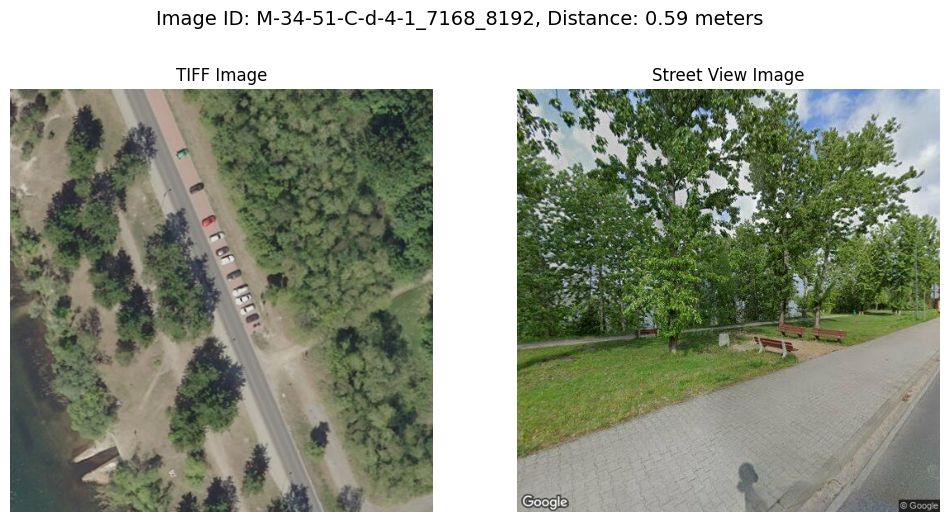

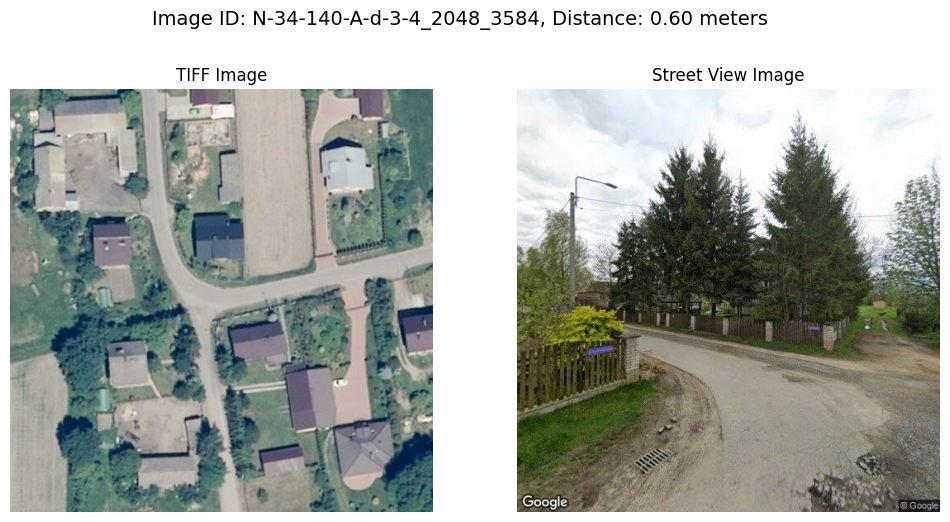

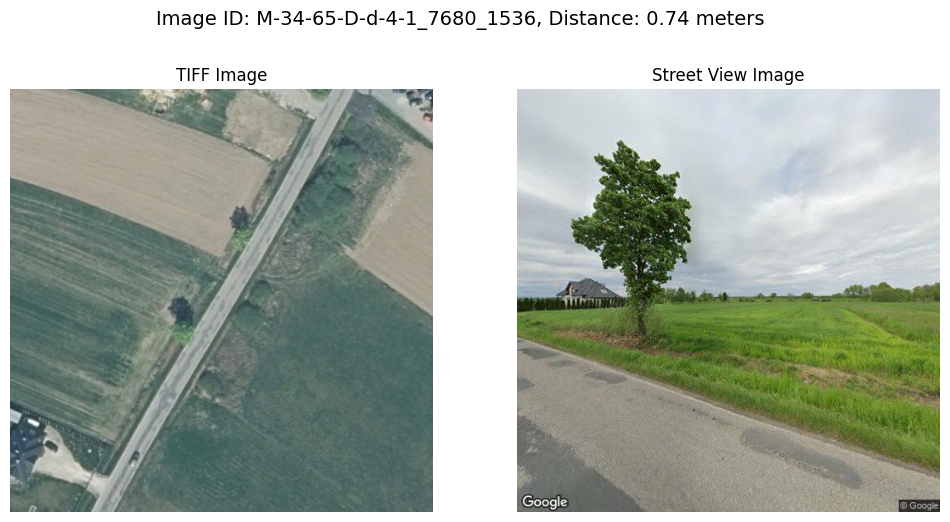

In [ ]:
# verify that the coordinates are right
import matplotlib.pyplot as plt
import glob

def get_top_3_samples_with_min_distance(txt_input, output_folder, tiff_folder):
    """
    Finds the 3 entries with the minimum distance from the text file and displays the
    corresponding TIFF and Street View images for verification.

    Parameters:
    - txt_input: Path to the text file containing coordinates and distances.
    - output_folder: Path where the Street View images are stored.
    - tiff_folder: Path where the original TIFF images are stored.
    """
    entries = []

    # Step 1: Read the text file and extract entries with distances
    with open(txt_input, 'r') as coord_file:
        header = coord_file.readline()  # Skip header line
        for line in coord_file:
            parts = line.strip().split(',')
            image_id = parts[0]

            # Check if the distance is available and is a number
            if parts[-1] != "N/A":
                distance = float(parts[-1])
                entries.append((image_id, distance, parts[1:5]))

    # Step 2: Sort entries by distance and get the top 3 with the minimum distance
    entries = sorted(entries, key=lambda x: x[1])[:3]

    # Step 3: Display the TIFF and Street View images for the top 3 entries
    for entry in entries:
        image_id, distance, coords = entry
        image_id = image_id[:-4]

        # Use glob to find the TIFF file with any extension
        tiff_paths = glob.glob(os.path.join(tiff_folder, f"{image_id}.*"))
        street_view_paths = glob.glob(os.path.join(output_folder, f"{image_id}.*"))

        # Check if we found matching files
        if not tiff_paths:
            print(f"No TIFF image found for {image_id}")
            continue
        if not street_view_paths:
            print(f"No Street View image found for {image_id}")
            continue

        # Open the first matching TIFF and Street View images
        tiff_image = Image.open(tiff_paths[0])
        street_view_image = Image.open(street_view_paths[0])

        # Step 4: Display the images side by side for verification
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Image ID: {image_id}, Distance: {distance:.2f} meters", fontsize=14)

        # Display the TIFF image
        plt.subplot(1, 2, 1)
        plt.title("TIFF Image")
        plt.imshow(tiff_image)
        plt.axis('off')

        # Display the Street View image
        plt.subplot(1, 2, 2)
        plt.title("Street View Image")
        plt.imshow(street_view_image)
        plt.axis('off')

        plt.show()

# Usage example
txt_input = '/content/drive/MyDrive/lcai_coords.txt'
output_folder = '/content/drive/MyDrive/lcai_street_images'
tiff_folder = '/content/drive/MyDrive/lcai_patches'

get_top_3_samples_with_min_distance(txt_input, output_folder, tiff_folder)



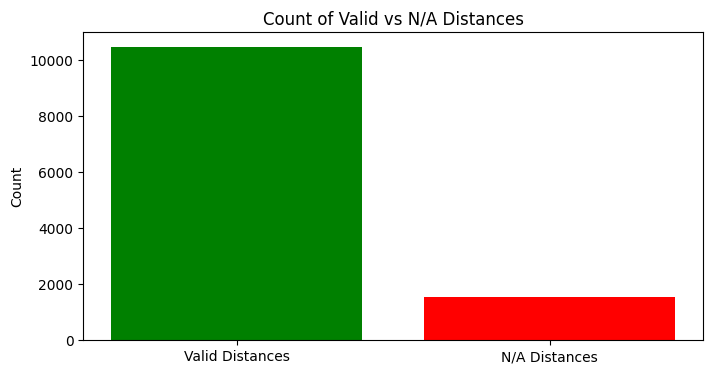

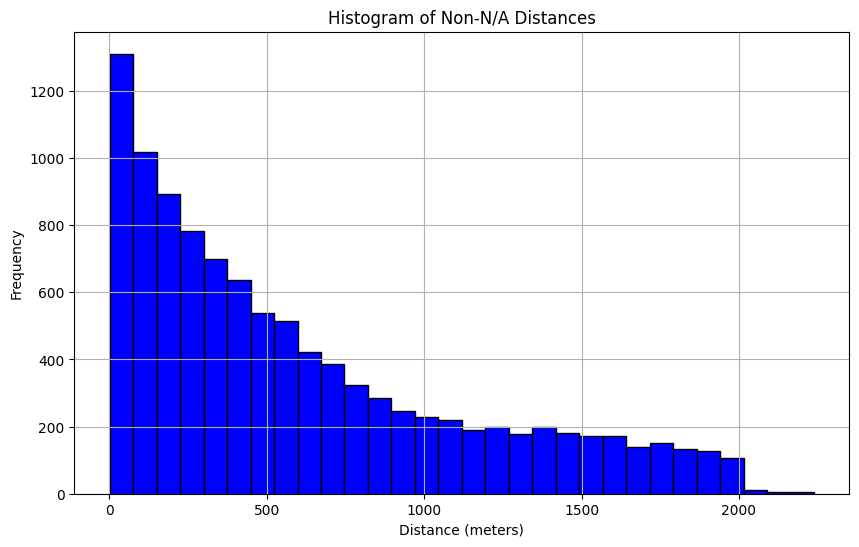

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_distances_from_txt(txt_input):
    # Step 1: Read the text file into a DataFrame
    df = pd.read_csv(txt_input)

    # Step 2: Convert the distance column to numeric, forcing errors to NaN for "N/A" entries
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')

    # Step 3: Count the number of N/A entries
    num_na = df['distance'].isna().sum()
    num_valid = df['distance'].notna().sum()

    # Step 4: Visualize the count of N/As and non-N/As
    plt.figure(figsize=(8, 4))
    plt.bar(['Valid Distances', 'N/A Distances'], [num_valid, num_na], color=['green', 'red'])
    plt.title("Count of Valid vs N/A Distances")
    plt.ylabel("Count")
    plt.show()

    # Step 5: Filter out N/A values for histogram
    valid_distances = df['distance'].dropna()

    # Step 6: Plot histogram of valid distances
    plt.figure(figsize=(10, 6))
    plt.hist(valid_distances, bins=30, color='blue', edgecolor='black')
    plt.title("Histogram of Non-N/A Distances")
    plt.xlabel("Distance (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Usage example
visualize_distances_from_txt(txt_input)